In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time

file_name = "spambase.data.shuffled"
df = pd.read_csv(file_name, header=0)
df.describe()    

,0.08,0.17,0.17.1,0,0.8,0.08.1,0.1,0.26,0.2,0.3,...,0.023,0.046,0.38,0.39,0.023.1,0.40,2.658,57,436,0.41
count,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,...,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,0.104559,0.213024,0.280680,0.065439,0.312117,0.095904,0.114233,0.105261,0.090087,0.239465,...,0.038578,0.139051,0.016980,0.269129,0.075822,0.044248,5.192066,52.171739,283.256087,0.394130
std,0.305391,1.290715,0.504195,1.395303,0.672547,0.273854,0.391480,0.401109,0.278643,0.644816,...,0.243498,0.270381,0.109406,0.815751,0.245908,0.429388,31.732876,194.912484,606.409587,0.488716
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.275500,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706250,43.000000,265.250000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [4]:
all_data = df.to_numpy()
X = all_data[:,:-1]
y = all_data[:,-1].squeeze()
split = 3450
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:] 
y_test = y[split:]
print(f"X_train: {X_train.shape}; y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}; y_test: {y_test.shape}")

X_train: (3450, 57); y_train: (3450,)
X_test: (1150, 57); y_test: (1150,)


In [5]:
def scale_array(X, scale):
    return (X - scale[0])/scale[1]

def to_zero_one(y):
    y_conv = y
    y_conv[y >= 0] = 1
    y_conv[y < 0] = 0
    return y_conv

def to_pos_neg(y, val=1):
    y_conv = y
    y_conv[y >= 0.5] = val
    y_conv[y < 0.5] = -val
    return y_conv

# scale X
X_mean = X_train.mean(axis=0).reshape(1, -1)
X_stddev = np.sqrt(X_train.var(axis=0).reshape(1, -1))
scale = (X_mean, X_stddev)
X_train = scale_array(X_train, scale)
# scale test according to the training scale
X_test = scale_array(X_test, scale)

In [6]:
class BinaryStump:
    def __init__(self, num_features):
        """
        Arguments:
            num_features: number of features
            scale: (mean, stddev) of the data
        """
        self.num_features = num_features
        self.feature = None
        self.thres = None
        self.thres_type = None # True = positive or False = negative
    
    def train(self, X, y):
        # sort by feature
        best_score = -np.inf
        if X.shape[1] != self.num_features:
            raise ValueError(f"Expected input of shape {self.num_features}, got {X.shape[1]}")
        n_samples = y.size
        num_ones = np.sum(y >= 0.5)
        num_zeros = n_samples - num_ones
        for i in range(self.num_features):
            idxs = np.argsort(X[:, i], kind='stable')
            y_sorted = y[idxs]
            # Can this be vectorized?
            left0, right1, left1, right0 = 0, num_ones, 0, num_zeros
            score, best_j = -np.inf, 0
            thres_type = None
            delta = 1e-6
            last_thres = X[idxs[best_j], i] - delta
            for j in range(n_samples):
                if y_sorted[j] >= 0.5:
                    left1 += 1
                    right1 -= 1
                else:
                    left0 += 1
                    right0 -= 1
                if last_thres != X[idxs[j], i]:
                    pscore = left0 + right1
                    nscore = left1 + right0
                    localscore = max(pscore, nscore)
                    if score < localscore:
                        last_thres = X[idxs[j], i]
                        score = localscore
                        best_j = j
                        thres_type = pscore >= nscore
            thres = X[idxs[best_j], i]
            ttype = thres_type
            if best_score < score:
                self.feature = i
                self.thres = thres
                self.thres_type = ttype
                best_score = score
                self.thres_idx = best_j

    def fit(self, X, y):
        self.train(X, y)
        return self
    
    def score(self, X, y):
        return np.sum(self(X) == y)/y.size

    def __call__(self, X):
        if X.shape[1] != self.num_features:
            raise ValueError(f"Expected input of shape {self.num_feature}, got {X.shape[1]}")
        if self.thres_type:
            y = X[:, self.feature] > self.thres
        else:
            y = X[:, self.feature] < self.thres
        return 1.0 * y
    
    def predict(self, X):
        return self(X)

In [7]:
class Ensemble:
    def __init__(self):
        self.models = []
        self.weights = []

    def add(self, model, weight):
        self.models.append(model)
        self.weights.append(weight)

    def __call__(self, X):
        y = np.zeros(X.shape[0])
        for i in range(len(self.models)):
            y += self.weights[i] * to_pos_neg(self.models[i].predict(X))
        return 1.0 * (y >= 0)
    
    def score(self, X, y):
        y_hat = self(X)
        return np.sum(y_hat == y)/y.size

    def eval(self, X, y):
        return 1 - self.score(X, y)

In [8]:
class AdaBoost:
    def __init__(self, Learner, X, y):
        self.Learner = Learner
        self.X_train = X
        # self.y_train = to_pos_neg(y)
        self.y_train = y
        self.n_samples = self.X_train.shape[0]
        self.distr = np.ones(self.n_samples) / (self.n_samples)
        self.ensemble = Ensemble()

    def train(self, n_steps, test_samples=None):
        """
        Arguments:
            n_steps : number of additional steps
            ss_size : sub sample size to train base classifier
        """
        errs = np.zeros(n_steps)
        test_errs = np.zeros(n_steps)
        alphas = np.zeros(n_steps)
        if test_samples is not None:
            X_test, y_test = test_samples
        for t in range(n_steps):
            ss_idxs = np.random.choice(self.distr.size, self.distr.size, p=self.distr, replace=True)
            ss_idxs = np.unique(ss_idxs)
            X_base_train = self.X_train[ss_idxs, :]
            y_base_train = self.y_train[ss_idxs]
            base_classifier = self.Learner().fit(X_base_train, y_base_train)
            eps = 1 - base_classifier.score(X_base_train, y_base_train)
            if eps >= 0.5:
                print(f"Warning: Weak learner failed to predict better than chance {eps}")
                break
            alpha = 0.5 * np.log((1-eps)/(eps+1e-8))
            alpha_bar = np.sqrt((1-eps)/(eps+1e-8))
            alphas[t] = eps
            y_hat = base_classifier.predict(self.X_train)
            update_vec = alpha_bar * np.ones(self.n_samples)
            update_vec[y_hat == self.y_train] = 1/alpha_bar
            
            self.distr = self.distr * update_vec
            # normalize by sum to ensure probability sums to 1
            self.distr = self.distr / np.sum(self.distr)
            self.ensemble.add(base_classifier, alpha)
            errs[t] = self.ensemble.eval(self.X_train, self.y_train)
            if test_samples is not None:
                test_errs[t] = self.ensemble.eval(X_test, y_test)
        if test_samples is not None:
            return (errs, test_errs)
        else:
            return errs
    
    def score(self, X, y):
        return self.ensemble.score(X, y)

10 | elapsed=2.966601610183716s
100 | elapsed=12.94502878189087s
1000 | elapsed=254.19217824935913s


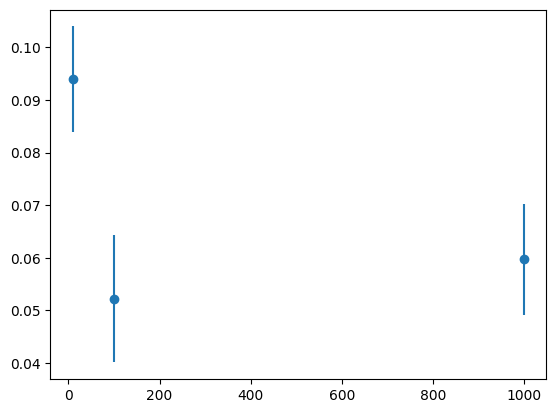

In [9]:
def ChopArray(x, start, offset):
    test = x[start:start+offset]
    if (x.shape == 2):
        rest = np.vstack([x[0:start], x[start+offset+1:]])
    else:
        rest = np.concatenate([x[0:start], x[start+offset+1:]])
    return (rest, test)

n_samples = y_train.size
offset = split // 10
rand_idx = np.random.permutation(n_samples)
X_shuffled = X_train[rand_idx, :]
y_shuffled = y_train[rand_idx]

n_iters_arr = [10**k for k in range(1, 4)]
mean_err_arr = np.zeros(len(n_iters_arr))
std_err_arr = np.zeros(len(n_iters_arr))
for i in range(len(n_iters_arr)):
    errs = np.zeros(10)
    n_procs = 16
    num_iters = n_iters_arr[i]
    start_time = time()
    for j in range(10):
        start = j * offset
        X_shf_train, X_shf_test = ChopArray(X_shuffled, start, offset)
        y_shf_train, y_shf_test = ChopArray(y_shuffled, start, offset)
        learner = lambda: BinaryStump(X_shf_train.shape[1])
        boosting_stumps = AdaBoost(learner, X_shf_train, y_shf_train)
        boosting_stumps.train(num_iters)
        errs[j] = 1 - boosting_stumps.score(X_shf_test, y_shf_test)
    delta_time = time() - start_time
    print(f"{num_iters} | elapsed={delta_time}s")
    mean_err_arr[i] = np.mean(errs)
    std_err_arr[i] = np.std(errs)

plt.errorbar(n_iters_arr, mean_err_arr, std_err_arr, linestyle='None', marker='o')
plt.show()

best parameter T* = 100


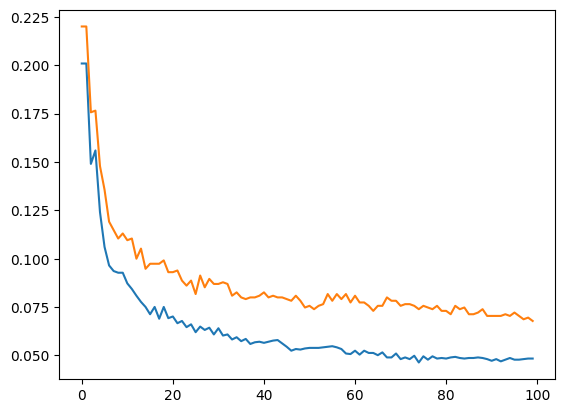

training error at 100: 0.04840579710144932; acc=0.9515942028985507
test error at 100: 0.0678260869565217, acc=0.9321739130434783


In [14]:
# plot training and test errors with best T
best_t = n_iters_arr[np.argmin(mean_err_arr)]
print(f"best parameter T* = {best_t}")

learner = lambda: BinaryStump(X_train.shape[1])
boosting_stumps = AdaBoost(learner, X_train, y_train)
train_err, test_err = boosting_stumps.train(best_t, (X_test, y_test))
plt.plot(train_err)
plt.plot(test_err)
plt.show()

print(f"training error at {best_t}: {train_err[-1]}; acc={1-train_err[-1]}")
print(f"test error at {best_t}: {test_err[-1]}, acc={1-test_err[-1]}")